# Project III - Collaboration and Competition


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
# when running in Udacity workspace
!pip -q install ./python

In [ ]:
from agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment

%matplotlib inline

In [ ]:
## when running locally
env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [ ]:
# Training a model and measuring its performance against a previously solved model
SOLVED_SCORE = 0.5
CONSEC_EPISODES = 100
PRINT_EVERY = 10
ADD_NOISE = True

In [ ]:
# MADDPG function

def maddpg(n_episodes=2000, max_t=1000, train_mode=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode

    """
    scores_window = deque(maxlen=CONSEC_EPISODES)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= SOLVED_SCORE:
            if not already_solved:
                print('<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-CONSEC_EPISODES, moving_average[-1], CONSEC_EPISODES))
                already_solved = True
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'ckpt_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'ckpt_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'ckpt_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'ckpt_critic_1.pth')
            elif ep_best_score >= best_score:
                print('<-- Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'ckpt_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'ckpt_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'ckpt_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'ckpt_critic_1.pth')
            elif (i_episode-best_episode) >= 200:
                # stop training if model stops converging
                print('<-- Training stopped. Best score not matched or exceeded for 200 episodes')
                break
            else:
                continue
            
    return scores_all, moving_average

In [ ]:
def get_actions(states, add_noise):
    '''gets actions for each agent and then combines them into one array'''
    action_0 = agent_0.act(states, add_noise)    # agent 0 chooses an action
    action_1 = agent_1.act(states, add_noise)    # agent 1 chooses an action
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [ ]:
# initialize agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

# Training the Model

In [ ]:
# run the training loop

# BUFFER_SIZE = int(1e6)  # replay buffer size
# BATCH_SIZE = 128        # minibatch size
# LR_ACTOR = 1e-3         # learning rate of the actor
# LR_CRITIC = 1e-3        # learning rate of the critic
# WEIGHT_DECAY = 0        # L2 weight decay
# LEARN_EVERY = 1         # learning timestep interval
# LEARN_NUM = 1           # number of learning passes
# GAMMA = 0.99            # discount factor
# TAU = 7e-2              # for soft update of target parameters
# OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
# OU_THETA = 0.12         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
# EPS_START = 5.5         # initial value for epsilon in noise decay process in Agent.act()
# EPS_EP_END = 250        # episode to end the noise decay process
# EPS_FINAL = 0           # final value for epsilon after decay

scores, avgs = maddpg()

Episodes 0000-0010	Max Reward: 0.100	Moving Average: 0.040
Episodes 0010-0020	Max Reward: 0.100	Moving Average: 0.025
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.017
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.018
Episodes 0040-0050	Max Reward: 0.100	Moving Average: 0.016
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.017
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.019
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.020
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.026
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.026
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.023
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.026
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.029
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.034
Episodes 0140-0150	Max Reward: 0.100	Moving Average: 0.042
Episodes 0150-0160	Max Reward: 0.200	Moving Average: 0.046
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

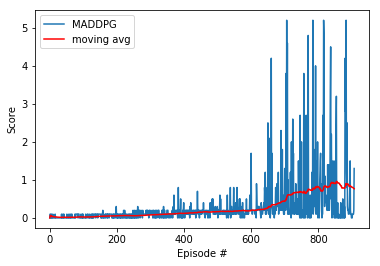

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()